In [ ]:
import pandas as pd
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import h5py
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import seaborn as sns # For confusion matrix visualization
#make a 2D projection of the data
!pip install -q umap-learn
import umap
import plotly.express as px
from tqdm import tqdm
import pickle
import joblib
import torch

In [ ]:
# mount to google drive to access csv located in my google drive
drive.mount('/content/drive/')
#os.getcwd()
os.chdir('drive/MyDrive/GradSchool/CHEM_269/Act2')

Mounted at /content/drive/


In [ ]:
# import steroid data

df_pos = pd.read_excel('steroids_positive_entries_020825.xlsx')
df_neg = pd.read_excel('steroids_negative_entries_020825.xlsx')
# add a column to each dataframe that indicates whether or not it's steroid interacting
# so that when we merge them we will have that indentifier
df_pos['steroid_interacting'] = True
df_neg['steroid_interacting'] = False
# concatenate the positive and negative dataframes
df_both = pd.concat([df_pos, df_neg], axis = 0)
df_both.reset_index(drop=True, inplace=True)

df_both = df_both.sort_values(by = 'Entry').reset_index(drop=True)

#import embeddings

filename_list = ['steroids_positive_entries.h5', 'steroids_negative_entries.h5']

#to create an empty dictionary use curly brackets!!
embeddings = {}

for filename in filename_list:
  with h5py.File(filename, 'r') as f:
    for entry, embedding in f.items():
      embeddings[entry] = np.array(embedding)

#fixed to extract
identifiers = sorted(embeddings.keys())
data_matrix = np.array([embeddings[entry_id] for entry_id in identifiers])



In [ ]:
#umap dimensionality reduction
reducer = umap.UMAP(metric = 'cosine',
                    random_state = 42)

umap_projection = reducer.fit_transform(data_matrix)
# add umap data to corresponding entries
umap_df = pd.DataFrame(umap_projection, columns = ['umap-1', 'umap-2'])
umap_df['Entry'] = identifiers

# add umap data to our merged steroid dataframe
df_both = pd.merge(df_both, umap_df, on = 'Entry', how = 'left')

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [ ]:
fig = px.scatter(
    df_both,
    x = 'umap-1',
    y = 'umap-2',
    color = 'steroid_interacting',
    hover_data = ['Entry', 'Protein names'],
    title = 'UMAP projection of steroid data',
    width = 1000,
    height = 700,
    color_discrete_map = {True: 'blue', False: 'orange'},
    opacity = 0.3 #
    )
fig.show()

# [EXERCISE 1]
#### Clustering in embedding space

In [ ]:
def cluster_embeddings(embeddings, distance_threshold):
    """
    Cluster embeddings using a CD-HIT like approach with cosine distance.
    Assumes we want all pairs of embeddings in different clusters to have
    distance > threshold.
    Args:
        embeddings: numpy array of shape (n_samples, n_features)
        distance_threshold: float, maximum cosine distance for clusters
    """
    n_samples = len(embeddings)


    # Normalize embeddings for cosine distance - do this once
    print("\nNormalizing embeddings...")
    norms = np.linalg.norm(embeddings, axis=1)
    normalized_embeddings = embeddings / norms[:, np.newaxis]


    # Initialize clusters
    cluster_labels = np.full(n_samples, -1)  # -1 means unassigned
    current_cluster = 0
    cluster_representatives = []  # Store indices of cluster representatives


    print("\nStarting clustering...")


    # First sequence becomes first cluster representative
    cluster_representatives.append(0)
    cluster_labels[0] = current_cluster
    current_cluster += 1


    # For each remaining sequence
    for i in tqdm(range(1, n_samples), desc="Clustering"):
        # Calculate distances to all cluster representatives
        # Since vectors are normalized, dot product gives cosine similarity directly
        similarities = np.dot(normalized_embeddings[i],
                            normalized_embeddings[cluster_representatives].T)
        distances = 1 - similarities


        # If all distances are greater than threshold, start new cluster
        if np.all(distances > distance_threshold):
            cluster_representatives.append(i)
            cluster_labels[i] = current_cluster
            current_cluster += 1
        else:
            # Assign to closest cluster within threshold
            closest_cluster = cluster_labels[cluster_representatives[np.argmin(distances)]]
            cluster_labels[i] = closest_cluster


    print(f"\nFinished clustering. Found {current_cluster} clusters")


    return cluster_labels


In [ ]:
cluster_labels = cluster_embeddings(data_matrix, 0.4)


Normalizing embeddings...

Starting clustering...


Clustering: 100%|██████████| 27748/27748 [00:34<00:00, 810.92it/s] 


Finished clustering. Found 1324 clusters


In [ ]:
len(data_matrix), len(cluster_labels) #these should be the same bc there should be one label per item in data_matrix

(27749, 27749)

In [ ]:
cluster_labels[-30:]

array([  387,    24,    37,   429, 12793,  4270,   154,  9041,   123,
       12794, 12795, 12796,    11,  1847,  4142,  1052,     0, 11575,
        7985,  4548,   268,  9151,    49,   971,    49, 12797,  3431,
       12798,    23,    23])

In [ ]:
#size of different clusters
cluster_sizes = np.bincount(cluster_labels)
print(cluster_sizes)

[1681   34   17 ...    1    1    1]


In [ ]:
#number of clusters
n_clusters = len(np.unique(cluster_labels))
print(n_clusters)

#distribution of cluster sizes
cluster_sizes = np.bincount(cluster_labels)
print("\nCluster size statistics:")
print(f"Mean size: {np.mean(cluster_sizes)}") #the mean size being small (~2 proteins) means that this distance threshold is too small
print(f"Min size: {np.min(cluster_sizes)}")
print(f"Max size: {np.max(cluster_sizes)}")

print("\nSize of first 10 clusters")
for i in range(min(10, n_clusters)):
  print(f"Cluster {i}: {np.sum(cluster_labels ==i)} proteins")

#


1324

Cluster size statistics:
Mean size: 20.95845921450151
Min size: 1
Max size: 1681

Size of first 10 clusters
Cluster 0: 1681 proteins
Cluster 1: 34 proteins
Cluster 2: 17 proteins
Cluster 3: 1098 proteins
Cluster 4: 487 proteins
Cluster 5: 715 proteins
Cluster 6: 46 proteins
Cluster 7: 26 proteins
Cluster 8: 33 proteins
Cluster 9: 66 proteins


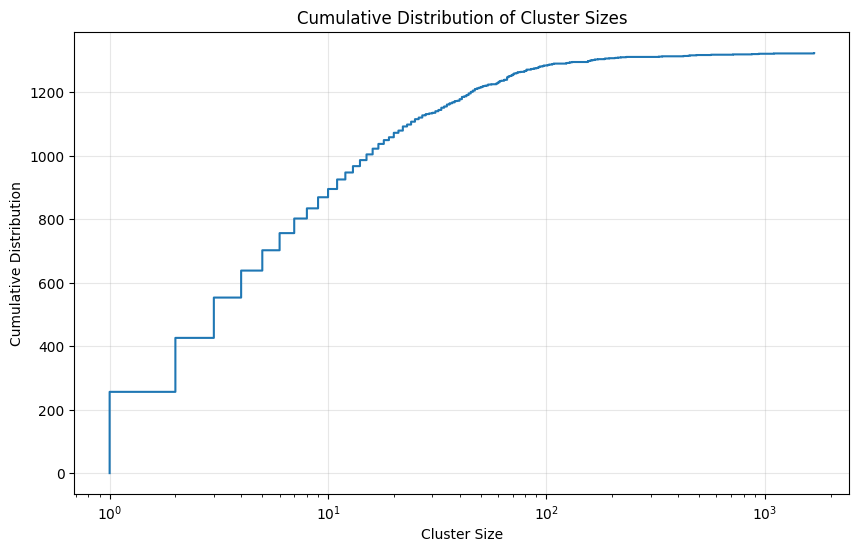

In [ ]:
cluster_sizes = cluster_sizes[cluster_sizes>0]

sorted_sizes = np.sort(cluster_sizes)

y = np.arange(1, len(sorted_sizes) + 1 / len(sorted_sizes))

plt.figure(figsize=(10, 6))
plt.step(sorted_sizes, y, where='post')
plt.xscale('log')
plt.grid(True, alpha=0.3)

plt.xlabel('Cluster Size')
plt.ylabel('Cumulative Distribution')
plt.title('Cumulative Distribution of Cluster Sizes')
plt.show()

In [ ]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
cluster_results = {}

for threshold in thresholds:
  cluster_labels = cluster_embeddings(data_matrix, distance_threshold=threshold)
  cluster_results[threshold] = cluster_labels

for threshold, labels in cluster_results.items():
  print(f"Threshold: {threshold}, Cluster Labels:{labels}")




#print(f"Cluster labels for threshold 0.4: {cluster_results[0.4]}")


Normalizing embeddings...

Starting clustering...


Clustering: 100%|██████████| 27748/27748 [04:10<00:00, 110.76it/s]



Finished clustering. Found 12799 clusters

Normalizing embeddings...

Starting clustering...


Clustering: 100%|██████████| 27748/27748 [01:55<00:00, 240.28it/s]



Finished clustering. Found 7819 clusters

Normalizing embeddings...

Starting clustering...


Clustering: 100%|██████████| 27748/27748 [00:53<00:00, 522.40it/s]



Finished clustering. Found 3677 clusters

Normalizing embeddings...

Starting clustering...


Clustering: 100%|██████████| 27748/27748 [00:11<00:00, 2393.40it/s]



Finished clustering. Found 1324 clusters

Normalizing embeddings...

Starting clustering...


Clustering: 100%|██████████| 27748/27748 [00:03<00:00, 7984.15it/s]


Finished clustering. Found 414 clusters
Threshold: 0.1, Cluster Labels:[    0     0     0 ... 12798    23    23]
Threshold: 0.2, Cluster Labels:[  0   0   0 ... 203 837 837]
Threshold: 0.3, Cluster Labels:[  0   0   0 ... 167  28  28]
Threshold: 0.4, Cluster Labels:[  0   0   0 ... 699  22  22]
Threshold: 0.5, Cluster Labels:[ 0  0  0 ... 48 15 15]


In [ ]:
#save pkl file

output_file = "cluster_results.pkl"
joblib.dump(cluster_results, output_file)

['cluster_results.pkl']

# [EXERCISE 2]
### Smart Test/Train splitting using our clustering results

In [ ]:
def sample_clusters_for_split(cluster_labels, target_train_fraction=0.8):
    """
    Randomly sample clusters until we get approximately target_fraction of proteins


    Args:
        cluster_labels: array where each element is a cluster ID for that protein
        target_train_fraction: what fraction of total proteins we want in training
    """
    total_proteins = len(cluster_labels)
    target_train_size = int(total_proteins * target_train_fraction)


    # Get unique cluster IDs and shuffle them
    cluster_ids = np.unique(cluster_labels)
    np.random.shuffle(cluster_ids)


    # Keep track of how many proteins we've accumulated
    current_size = 0
    train_clusters = []


    # Keep adding clusters until we reach target size
    for cluster_id in cluster_ids:
        cluster_size = np.sum(cluster_labels == cluster_id)
        if current_size + cluster_size <= target_train_size:
            train_clusters.append(cluster_id)
            current_size += cluster_size


    # Remaining clusters go to test
    test_clusters = [c for c in cluster_ids if c not in train_clusters]


    # Get the protein indices for each set
    train_mask = np.isin(cluster_labels, train_clusters)
    test_mask = np.isin(cluster_labels, test_clusters)


    print(f"Split results:")
    print(f"Training set: {np.sum(train_mask)} proteins ({np.sum(train_mask)/total_proteins:.2%})")
    print(f"Test set: {np.sum(test_mask)} proteins ({np.sum(test_mask)/total_proteins:.2%})")


    return train_mask, test_mask

In [ ]:
cluster_labels = cluster_results[0.3]
#get training and testing masks for the 0.3 threshold
train_mask, test_mask = sample_clusters_for_split(cluster_labels, target_train_fraction=0.8)
#the masks will be true/false which will correspond to whether a protein is or is not steroid binding

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)


In [ ]:
X_train = data_matrix[train_mask] #embeddings
X_test = data_matrix[test_mask]

y_train = df_both['steroid_interacting'].values[train_mask] #human readable characteristics
y_test = df_both['steroid_interacting'].values[test_mask]

train_proteins = df_both['Entry'].values[train_mask] #proteins associated with the train and test masks
test_proteins = df_both['Entry'].values[test_mask]

In [ ]:
# define the models we will train
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric = 'logloss'),
    'Random Forest': RandomForestClassifier(random_state=42)
}


In [ ]:
results = []

#instead of iterating through all models we will just use LR because it is fastest
name = "Logistic Regression"
model = models[name]

print(f"\nEvaluating {name}")

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
calc_f1_score = f1_score(y_test, y_pred)
roc_score = roc_auc_score(y_test, y_pred)

results.append({
    'Model': name,
    'Accuracy': f"{accuracy:.3f}",
    'Precision': f"{precision:.3f}",
    'Recall': f"{recall:.3f}",
    'F1 Score': f"{calc_f1_score:.3f}",
    'ROC AUC Score': f"{roc_score:.3f}"
})

df_results = pd.DataFrame(results)


Evaluating Logistic Regression


In [ ]:
df_results #these metrics are pretty bad and very different from when we randomly split the data!!

Model Accuracy Precision Recall F1 Score ROC AUC Score
0  Logistic Regression    0.945     0.910  0.705    0.794         0.846

# [EXERCISE 3]
### More robust model evaluation for multiple thresholds

In [ ]:
#open pre-computed clusters if need be
with open("cluster_results.pkl", "rb") as f:
  cluster_results = pickle.load(f)

In [ ]:
#thresholds to iterate through
thresholds = list(cluster_results.keys())
#number of times to repeat per threshold
num_repeats = 10

model = LogisticRegression(max_iter=1000)

for threshold in tqdm(thresholds, desc = "Testing Thresholds"):
  print(f"\nEvaluating threshold {threshold}")

  auc_scores = []
  cluster_labels = cluster_results[threshold]

  for _ in tqdm(range(num_repeats), desc='Reapeating random cluster samplings'):
    train_mask, test_mask = sample_clusters_for_split(cluster_labels, target_train_fraction=0.8)

    X_train = data_matrix[train_mask]
    X_test = data_matrix[test_mask]
    y_train = df_both['steroid_interacting'].values[train_mask]
    y_test = df_both['steroid_interacting'].values[test_mask]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    roc_score = roc_auc_score(y_test, y_pred)
    auc_scores.append(roc_score)

  threshold_results.append({
      'Threshold': threshold,
      'Mean ROC AUC': np.mean(auc_scores),
      'Std ROC AUC': np.std(auc_scores)
  })

results_df = pd.DataFrame(threshold_results)

results_df.to_csv("threshold_results.csv", index=False)

Testing Thresholds:   0%|          | 0/5 [00:00<?, ?it/s]


Evaluating threshold 0.1



Reapeating random cluster samplings:   0%|          | 0/10 [00:00<?, ?it/s]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  10%|█         | 1/10 [00:02<00:19,  2.12s/it]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  20%|██        | 2/10 [00:04<00:16,  2.06s/it]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  30%|███       | 3/10 [00:07<00:17,  2.51s/it]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  40%|████      | 4/10 [00:09<00:13,  2.30s/it]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  50%|█████     | 5/10 [00:11<00:11,  2.39s/it]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  60%|██████    | 6/10 [00:15<00:11,  2.95s/it]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  70%|███████   | 7/10 [00:18<00:08,  2.90s/it]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  80%|████████  | 8/10 [00:20<00:05,  2.68s/it]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  90%|█████████ | 9/10 [00:23<00:02,  2.62s/it]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Testing Thresholds:  20%|██        | 1/5 [00:26<01:46, 26.50s/it]


Evaluating threshold 0.2



Reapeating random cluster samplings:   0%|          | 0/10 [00:00<?, ?it/s]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  10%|█         | 1/10 [00:02<00:18,  2.01s/it]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  20%|██        | 2/10 [00:04<00:19,  2.44s/it]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  30%|███       | 3/10 [00:06<00:14,  2.05s/it]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  40%|████      | 4/10 [00:07<00:10,  1.71s/it]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  50%|█████     | 5/10 [00:08<00:07,  1.56s/it]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  60%|██████    | 6/10 [00:10<00:05,  1.46s/it]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  70%|███████   | 7/10 [00:11<00:04,  1.42s/it]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  80%|████████  | 8/10 [00:12<00:02,  1.35s/it]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  90%|█████████ | 9/10 [00:13<00:01,  1.33s/it]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Testing Thresholds:  40%|████      | 2/5 [00:41<00:59, 19.80s/it]


Evaluating threshold 0.3



Reapeating random cluster samplings:   0%|          | 0/10 [00:00<?, ?it/s]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  10%|█         | 1/10 [00:01<00:09,  1.10s/it]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  20%|██        | 2/10 [00:02<00:09,  1.16s/it]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  30%|███       | 3/10 [00:03<00:07,  1.11s/it]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  40%|████      | 4/10 [00:04<00:05,  1.05it/s]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  50%|█████     | 5/10 [00:04<00:04,  1.10it/s]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  60%|██████    | 6/10 [00:05<00:03,  1.13it/s]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  70%|███████   | 7/10 [00:06<00:02,  1.17it/s]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  80%|████████  | 8/10 [00:07<00:01,  1.21it/s]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  90%|█████████ | 9/10 [00:08<00:00,  1.25it/s]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Testing Thresholds:  60%|██████    | 3/5 [00:50<00:29, 14.88s/it]


Evaluating threshold 0.4



Reapeating random cluster samplings:   0%|          | 0/10 [00:00<?, ?it/s]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  10%|█         | 1/10 [00:00<00:05,  1.61it/s]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  20%|██        | 2/10 [00:01<00:05,  1.59it/s]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  30%|███       | 3/10 [00:02<00:04,  1.43it/s]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  40%|████      | 4/10 [00:02<00:04,  1.45it/s]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  50%|█████     | 5/10 [00:03<00:03,  1.42it/s]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  60%|██████    | 6/10 [00:04<00:03,  1.31it/s]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  70%|███████   | 7/10 [00:05<00:02,  1.23it/s]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  80%|████████  | 8/10 [00:06<00:01,  1.09it/s]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  90%|█████████ | 9/10 [00:07<00:00,  1.16it/s]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Testing Thresholds:  80%|████████  | 4/5 [00:58<00:12, 12.13s/it]


Evaluating threshold 0.5



Reapeating random cluster samplings:   0%|          | 0/10 [00:00<?, ?it/s]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  10%|█         | 1/10 [00:00<00:06,  1.44it/s]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  20%|██        | 2/10 [00:01<00:05,  1.50it/s]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  30%|███       | 3/10 [00:02<00:04,  1.43it/s]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  40%|████      | 4/10 [00:02<00:04,  1.42it/s]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  50%|█████     | 5/10 [00:03<00:03,  1.51it/s]

Split results:
Training set: 22192 proteins (79.97%)
Test set: 5557 proteins (20.03%)



Reapeating random cluster samplings:  60%|██████    | 6/10 [00:04<00:02,  1.45it/s]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  70%|███████   | 7/10 [00:04<00:01,  1.56it/s]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  80%|████████  | 8/10 [00:05<00:01,  1.53it/s]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Reapeating random cluster samplings:  90%|█████████ | 9/10 [00:06<00:00,  1.43it/s]

Split results:
Training set: 22199 proteins (80.00%)
Test set: 5550 proteins (20.00%)



Testing Thresholds: 100%|██████████| 5/5 [01:05<00:00, 13.06s/it]


In [ ]:
results_df
#for some reason the 0.5 threshold was appended twice so I just delete it for the plot
results_df2 = results_df.iloc[1:5,:]

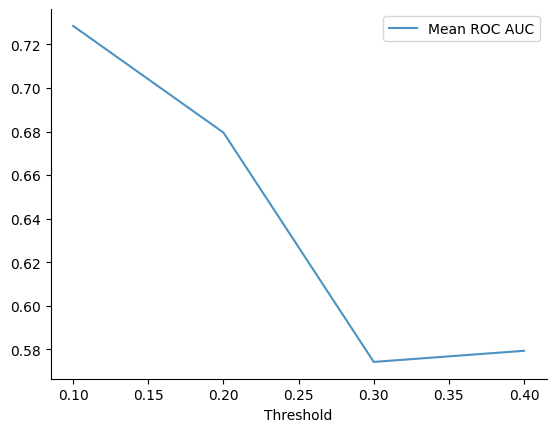

In [ ]:
results_df2.plot(kind='line', x = 'Threshold', y = 'Mean ROC AUC', alpha = 0.8)
plt.gca().spines[['top', 'right']].set_visible(False)

# [EXERCISE 4]
### Generating pairs

In [ ]:
cluster_labels = cluster_results[0.2]
df_both['cluster'] = cluster_labels
df_both.head()

Entry        Entry Name  \
0  A0A016VA76  A0A016VA76_9BILA   
1  A0A023EUU2  A0A023EUU2_AEDAL   
2  A0A023EUU7  A0A023EUU7_AEDAL   
3  A0A023FCJ4  A0A023FCJ4_TRIIF   
4  A0A024SC78       CUTI1_HYPJR   

                                       Protein names  \
0  Sterol carrier protein 2 (EC 2.3.1.155) (EC 2....   
1  Sterol carrier protein 2 (EC 2.3.1.155) (EC 2....   
2  Sterol carrier protein 2 (EC 2.3.1.155) (EC 2....   
3  Sterol carrier protein 2 (EC 2.3.1.155) (EC 2....   
4                             Cutinase (EC 3.1.1.74)   

                                    Gene Names  \
0  Acey_s0014.g2217 Acey-daf-22 Y032_0014g2217   
1                                          NaN   
2                                          NaN   
3                                          NaN   
4                              M419DRAFT_76732   

                                            Organism  Length  \
0                             Ancylostoma ceylanicum     531   
1  Aedes albopictus (Asian tiger mosquito) (Stego...     544   
2  Aedes albopictus (Asian tiger mosquito) (Stego...     544   
3                  Triatoma infestans (Assassin bug)     540   
4  Hypocrea jecorina (strain ATCC 56765 / BCRC 32...     248   

                                            Sequence  Annotation Rhea ID  \
0  MTKPKVFVIGVGMTKFCKPGSRDWDYPDMVKEAVTTALDDCKLKYS...           5   62960   
1  MGVPKVYVVGVGMTKFEKPGRRENFDYPQMAKEAVTKALNDARIQY...           5   62960   
2  MGVPKVYVVGVGMTKFEKPGRRENFDYPQMAKEAVTKALNDARIQY...           5   62960   
3  RVKVYVVGVGMTKFYKPGKSDKDYPELAKEAIMKALEDARINHDDV...           5   62960   
4  MRSLAILTTLLAGHAFAYPKPAPQSVNRRDWPSINEFLSELAKVMP...           5     NaN   

                                              SMILES  steroid_interacting  \
0  [H][C@@]1(CC[C@@]2([H])C3=CC=C4C[C@@H](O)CC[C@...                 True   
1  [H][C@@]1(CC[C@@]2([H])C3=CC=C4C[C@@H](O)CC[C@...                 True   
2  [H][C@@]1(CC[C@@]2([H])C3=CC=C4C[C@@H](O)CC[C@...                 True   
3  [H][C@@]1(CC[C@@]2([H])C3=CC=C4C[C@@H](O)CC[C@...                 True   
4                                                NaN                False   

     umap-1     umap-2  cluster  
0  5.435898  12.963628        0  
1  5.598622  13.172338        0  
2  5.595283  13.152024        0  
3  6.037452  13.462385        0  
4  6.396379   0.412718        1

In [ ]:
def get_positive_pairs(df, embeddings, N = 1000):
  """Randomly samples N positive pairs of steroid binding proteins """
  binders = df[df['steroid_interacting'] == True]["Entry"].tolist()
  positive_pairs = []

  for _ in range(N):
    p1, p2 = random.sample(binders, 2)
    positive_pairs.append((p1,p2,embeddings[p1], embeddings[p2]))

  return positive_pairs


def get_clustered_hard_negatives(df, embeddings, N = 1000):
  """ Finds N hard negative pairs using cluster info"""
  hard_negatives = []
  binders = df[df['steroid_interacting'] == True]
  non_binders = df[df['steroid_interacting'] == False]

  successful_hard_negatives = 0 #hard negatives in same cluster
  fallback_negatives = 0 # negatives where no non-binders are in the cluster

  for _ in range(N):
    binder = binders.sample(1).iloc[0] #randomly select a steroid binding protein
    cluster_id = binder["cluster"]

    #find non-binders in same cluster
    same_cluster_non_binders = non_binders[non_binders["cluster"] == cluster_id]["Entry"].tolist()

    if same_cluster_non_binders:
      neg = random.choice(same_cluster_non_binders)
      successful_hard_negatives += 1
    else:
      neg = random.choice(non_binders["Entry"].tolist())
      fallback_negatives += 1

    hard_negatives.append((binder["Entry"], neg, embeddings[binder["Entry"]], embeddings[neg])) #label = -1

  print(f"Hard negatives successfully sampled: {successful_hard_negatives}")
  print(f"Hard negatives with fallback: {fallback_negatives}")
  return hard_negatives


def get_random_negative_pairs(df, embeddings, N=1000):
  """Randomly samples N negative pairs (two non-steroid binders)"""
  binders = df[df["steroid_interacting"] == True]["Entry"].tolist()
  non_binders = df[df['steroid_interacting'] == False]["Entry"].tolist()
  random_negatives = []
  for _ in range(N):
    p1 = random.choice(non_binders)
    p2 = random.choice(non_binders)
    random_negatives.append((p1, p2, embeddings[p1], embeddings[p2], -1))
  return random_negatives

In [ ]:
# implement above functions

positive_pairs = get_positive_pairs(df_both, embeddings, N = 5000)
hard_negatives = get_clustered_hard_negatives(df_both, embeddings, N = 5000)
random_negatives = get_random_negative_pairs(df_both, embeddings, N = 5000)

all_pairs = positive_pairs + hard_negatives + random_negatives
random.shuffle(all_pairs)

Hard negatives successfully sampled: 3689
Hard negatives with fallback: 1311


In [ ]:
print(positive_pairs[0])

('A0A2J8KRV5', 'A0A818BEI0', array([ 0.00839013,  0.03676938, -0.01288575, ..., -0.02020978,
        0.00041576, -0.00845715], dtype=float32), array([ 0.04155283, -0.01127693,  0.03404083, ..., -0.04477821,
        0.03383632, -0.02529124], dtype=float32))


In [ ]:
with open("contrastive_pairs.pkl", "wb") as f:
  pickle.dump(all_pairs, f)

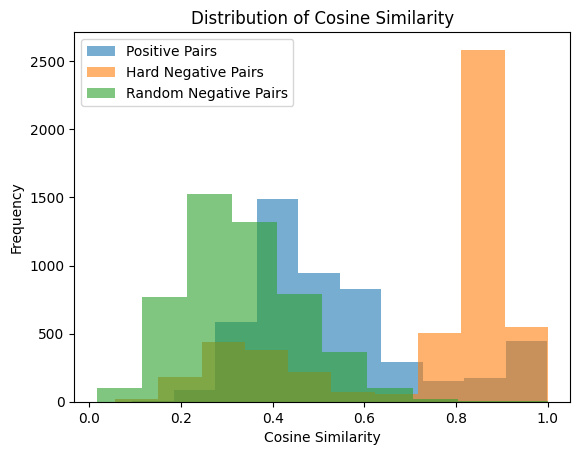

In [ ]:
def cosine_similarity(v1, v2):
  return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

pos_sim = [cosine_similarity(emb1, emb2) for _,_, emb1, emb2, in positive_pairs]
hard_neg_sim = [cosine_similarity(emb1, emb2) for _,_, emb1, emb2, in hard_negatives]
random_neg_sim = [cosine_similarity(emb1, emb2) for _,_, emb1, emb2, _ in random_negatives]

plt.hist(pos_sim, bins = 10, alpha=0.6, label = "Positive Pairs")
plt.hist(hard_neg_sim, bins = 10, alpha=0.6, label = "Hard Negative Pairs")
plt.hist(random_neg_sim, bins = 10, alpha=0.6, label = "Random Negative Pairs")
plt.legend()
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.title("Distribution of Cosine Similarity")
plt.show()

# [EXERCISE 5]


In [ ]:
# make random embeddings to test out making a loss function

#number of pairs
N = 2

#make random embeddings
z_i = torch.randn(N * 4, 128)
z_j = torch.randn(N * 4, 128)

#true positives
z_j [:N] = z_i[:N] + torch.randn_like(z_i[:N]) * 0.01
pos_labels = torch.ones(N)

#false positives
z_j[N:2*N] = torch.randn(N, 128)
false_pos_labels = torch.ones(N)

#true neagtives
neg_labels = -torch.ones(N)

#false negatives
z_i[3*N:4*N] = z_i[3*N:4*N] + torch.randn_like(z_i[3*N:4*N]) * 0.01
false_neg_labels = -torch.ones(N)

pair_labels = torch.cat([pos_labels, false_pos_labels, neg_labels, false_neg_labels], dim = 0)
print(pair_labels)

tensor([ 1.,  1.,  1.,  1., -1., -1., -1., -1.])


In [ ]:
#now that we have the dummy data, we can apply the loss funciton
import torch.nn as nn
import torch.nn.functional as F

#this is the contrastive loss function
loss_fn = nn.CosineEmbeddingLoss(margin = 0.4, reduction = 'none')

#compute cosine similarity for all pairs
cos_sim = F.cosine_similarity(z_i, z_j)

#compute contrastive loss for each pair
loss_per_pair = loss_fn(z_i, z_j, pair_labels)

#Get results
for i in range(4*N):
  if i < N:
    pair_type = "True positive"
  elif i < 2*N:
    pair_type = "False positive"
  elif i < 3*N:
    pair_type = "True negative"
  else:
    pair_type = "Flase negative"

  print(f"Pair {i}: {pair_type}, Cosine similarity: {cos_sim[i].item():.3f}, Loss: {loss_per_pair[i].item():.3f}")


Pair 0: True positive, Cosine similarity: 1.000, Loss: 0.000
Pair 1: True positive, Cosine similarity: 1.000, Loss: 0.000
Pair 2: False positive, Cosine similarity: -0.101, Loss: 1.101
Pair 3: False positive, Cosine similarity: 0.074, Loss: 0.926
Pair 4: True negative, Cosine similarity: -0.016, Loss: 0.000
Pair 5: True negative, Cosine similarity: 0.061, Loss: 0.000
Pair 6: Flase negative, Cosine similarity: 0.036, Loss: 0.000
Pair 7: Flase negative, Cosine similarity: -0.020, Loss: 0.000


# [EXERCISE 6]
### Train a contrastive learning model in pytorch

In [ ]:
#will use the all_pairs object, which I also have saved as the file contrastive_pairs.pkl
print(f"Using {len(all_pairs)} pairs")

#list comprehensions
z_i = torch.tensor([pair[2] for pair in all_pairs], dtype=torch.float) #first protein embedding
z_j = torch.tensor([pair[3] for pair in all_pairs], dtype=torch.float) #second protein embedding
#pair_labels = torch.tensor([pair[4] for pair in all_pairs], dtype=torch.float)
pair_labels = []
for pair in all_pairs:
    # Assuming positive_pairs and hard_negatives are at the beginning
    if len(pair) == 4:
        if pair in positive_pairs:
            pair_labels.append(1)  # Positive label
        else:
            pair_labels.append(-1) # Negative label (hard negative)
    else:  # Assuming random_negatives has length 5 and the label is in the last position
        pair_labels.append(pair[4])  # Get label from random_negatives

pair_labels = torch.tensor(pair_labels, dtype=torch.float)
print(f" Embedding shape: {z_i.shape}")


Using 15000 pairs
 Embedding shape: torch.Size([15000, 1024])


In [ ]:
pair_labels[:20]

tensor([-1., -1.,  1., -1., -1., -1., -1.,  1., -1.,  1., -1.,  1., -1., -1.,
        -1., -1.,  1.,  1., -1., -1.])

In [ ]:
import torch.nn as nn
from torch.nn import Sequential
import torch.nn.functional as F

class ContrastiveMLP(nn.Module):
  def __init__(self, input_size=1024, hidden_sizes = [512, 256, 128], output_size = 32):
    super(ContrastiveMLP, self).__init__()

    self.model = nn.Sequential(
        nn.Linear(input_size, hidden_sizes[0]),
        nn.ReLU(),
        nn.Linear(hidden_sizes[0], hidden_sizes[1]),
        nn.ReLU(),
        nn.Linear(hidden_sizes[1], hidden_sizes[2]),
        nn.ReLU(),
        nn.Linear(hidden_sizes[2], output_size)
    )

  def forward(self, x):
    return self.model(x)

In [ ]:
#instantiate the model
contrastive_model= ContrastiveMLP(input_size = 1024)

print(contrastive_model)

ContrastiveMLP(
  (model): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=32, bias=True)
  )
)


In [ ]:
#calculate the contrastive loss function for our embeddings

loss_fn = nn.CosineEmbeddingLoss(margin = 0.5)

#define an optimizer: this is a way to adjust the models weights while training
optimizer = torch.optim.Adam(contrastive_model.parameters(), lr = 0.001)

print(torch.cuda.is_available())
#print(torch.cuda.get_device_name(0))

False


In [ ]:
#Training the model!

#training parameters:
epochs = 100 #go through dataset 100 times
batch_size = 128
num_batches = len(z_i) // batch_size

for epoch in range(epochs):
  total_loss = 0.0

  for i in range(num_batches):
    start = i * batch_size
    end = start + batch_size
    batch_z_i = z_i[start:end]
    batch_z_j = z_j[start:end]
    batch_pair_labels = pair_labels[start:end]

    #compute embeddings
    emb_j = contrastive_model(batch_z_j)
    emb_i = contrastive_model(batch_z_i)

    #compute loss
    loss = loss_fn(emb_i, emb_j, batch_pair_labels)

    #backpropogation/optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  #print epoch loss
  avg_loss = total_loss / num_batches
  print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}")


Epoch 1/100, Average Loss: 0.1140
Epoch 2/100, Average Loss: 0.0562
Epoch 3/100, Average Loss: 0.0389
Epoch 4/100, Average Loss: 0.0317
Epoch 5/100, Average Loss: 0.0260
Epoch 6/100, Average Loss: 0.0216
Epoch 7/100, Average Loss: 0.0201
Epoch 8/100, Average Loss: 0.0197
Epoch 9/100, Average Loss: 0.0177
Epoch 10/100, Average Loss: 0.0163
Epoch 11/100, Average Loss: 0.0168
Epoch 12/100, Average Loss: 0.0137
Epoch 13/100, Average Loss: 0.0139
Epoch 14/100, Average Loss: 0.0117
Epoch 15/100, Average Loss: 0.0125
Epoch 16/100, Average Loss: 0.0130
Epoch 17/100, Average Loss: 0.0165
Epoch 18/100, Average Loss: 0.0108
Epoch 19/100, Average Loss: 0.0096
Epoch 20/100, Average Loss: 0.0105
Epoch 21/100, Average Loss: 0.0127
Epoch 22/100, Average Loss: 0.0104
Epoch 23/100, Average Loss: 0.0114
Epoch 24/100, Average Loss: 0.0159
Epoch 25/100, Average Loss: 0.0126
Epoch 26/100, Average Loss: 0.0100
Epoch 27/100, Average Loss: 0.0109
Epoch 28/100, Average Loss: 0.0097
Epoch 29/100, Average Loss: 0

In [ ]:
with torch.no_grad():
  #original plm embeddings before going through the models
  original_cosine_sim = F.cosine_similarity(z_i, z_j)

  #embeddings after the models
  emb_i_test = contrastive_model(z_i)
  emb_j_test = contrastive_model(z_j)
  contrastive_cosine_sim = F.cosine_similarity(emb_i_test, emb_j_test)
  test_labels = pair_labels

  #compute avg similarity for pos and neg pairs pre-training
  orig_pos_sim = original_cosine_sim[test_labels == 1].mean().item()
  orig_neg_sim = original_cosine_sim[test_labels == -1].mean().item()

  #compute avg similarity post-training
  post_pos_sim = contrastive_cosine_sim[test_labels == 1].mean().item()
  post_neg_sim = contrastive_cosine_sim[test_labels == -1].mean().item()

  print(f"Average cosine similarity for positive pairs before training: {orig_pos_sim:.4f}")
  print(f"Average cosine similarity for negative pairs before training: {orig_neg_sim:.4f}")
  print(f"Average cosine similarity for positive pairs after training: {post_pos_sim:.4f}")
  print(f"Average cosine similarity for negative pairs after training: {post_neg_sim:.4f}")





Average cosine similarity for positive pairs before training: 0.5352
Average cosine similarity for negative pairs before training: 0.5292
Average cosine similarity for positive pairs after training: 0.9984
Average cosine similarity for negative pairs after training: 0.0168


# [EXERCISE 7]
#### visualize our performance before and after training

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



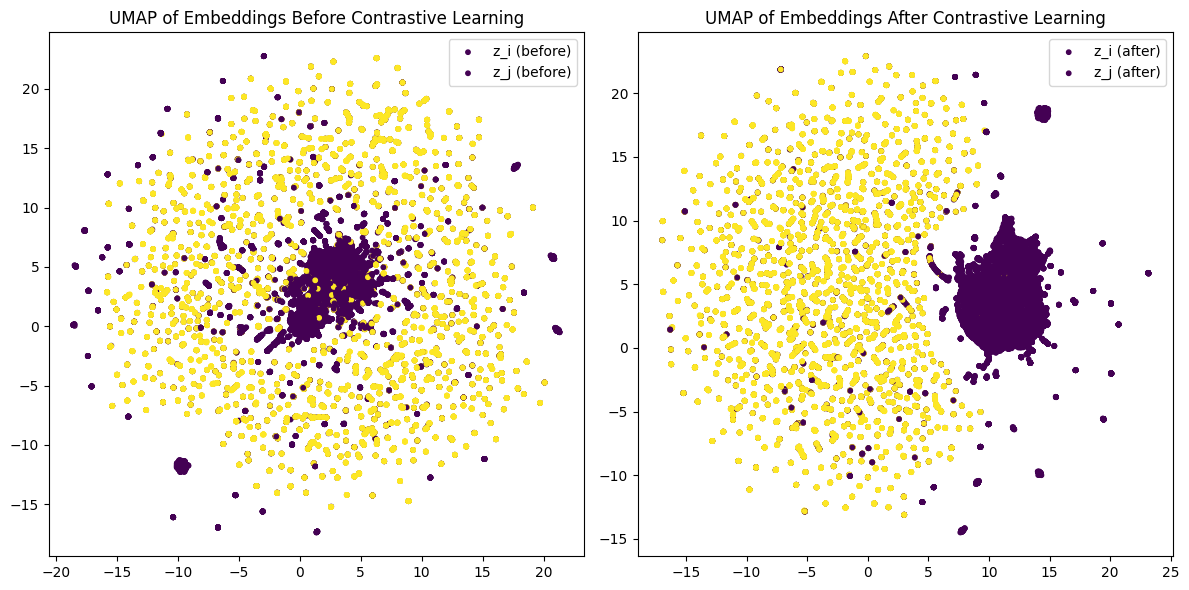

In [ ]:
# prompt: I want to visualize the UMAP of my 'before contrastive learning' PLM embeddings and my 'after contrastive learning' Plm embeddings. how would i do that?

import umap
import matplotlib.pyplot as plt

# Assuming 'z_i' and 'z_j' are your before and after embeddings, respectively
# and 'pair_labels' indicates whether each pair is positive (1) or negative (-1)

# Reduce dimensionality using UMAP
reducer = umap.UMAP(n_components=2, random_state=42)

# Before contrastive learning
before_embeddings = torch.cat((z_i, z_j), dim=0).numpy()
before_umap_embeddings = reducer.fit_transform(before_embeddings)

# After contrastive learning
after_embeddings = torch.cat((emb_i_test, emb_j_test), dim=0).numpy()
after_umap_embeddings = reducer.fit_transform(after_embeddings)


# Plotting
plt.figure(figsize=(12, 6))

# Before Contrastive Learning
plt.subplot(1, 2, 1)
plt.scatter(before_umap_embeddings[:len(z_i), 0], before_umap_embeddings[:len(z_i), 1], c=pair_labels[:len(z_i)], cmap='viridis', s=10, label='z_i (before)')
plt.scatter(before_umap_embeddings[len(z_i):, 0], before_umap_embeddings[len(z_i):, 1], c=pair_labels[:len(z_j)], cmap='viridis', s=10, label='z_j (before)')

plt.title('UMAP of Embeddings Before Contrastive Learning')
plt.legend()

# After Contrastive Learning
plt.subplot(1, 2, 2)
plt.scatter(after_umap_embeddings[:len(emb_i_test), 0], after_umap_embeddings[:len(emb_i_test), 1], c=test_labels, cmap='viridis', s=10, label='z_i (after)')
plt.scatter(after_umap_embeddings[len(emb_i_test):, 0], after_umap_embeddings[len(emb_i_test):, 1], c=test_labels, cmap='viridis', s=10, label='z_j (after)')
plt.title('UMAP of Embeddings After Contrastive Learning')
plt.legend()

plt.tight_layout()
plt.show()


### Comparing the two plots, it  separates the data more clearly, but there is still some overlap between positive and negative